- postgres_fdw 확장은 PostgreSQL 글로벌 개발 그룹이 공식적으로 유지 관리하는 특수 모듈
- 해당 소스 코드는 PostgreSQL 소스 코드 트리에 포함되어 있음

**postgres_fdw와 관련된 릴리스 노트**

|버전	|설명|
|--|--|
|9.3|postgres_fdw 모듈이 출시.|
|9.6|원격 서버에서 정렬을 수행하는 것을 고려 / 원격 서버에서 조인을 수행하는 것을 고려. / 가능하다면 원격 서버에서 완전히 UPDATE 또는 DELETE를 수행. / 가져오기 크기를 서버 또는 테이블 옵션으로 설정할 수 있도록 허용.|
|10|가능한 경우 집계 함수를 원격 서버에 푸시.|
|11|파티션인 외부 테이블에 집계를 푸시다운할 수 있음. / 외부 서버에 대한 조인을 사용하여 UPDATE 및 DELETE를 푸시할 수 있음.|
|12|더 많은 경우에 ORDER BY 정렬 및 LIMIT 절을 푸시할 수 있음.|
|14|TRUNCATE가 외부 테이블에서 작동하도록 허용합니다. INSERT 행을 대량으로 허용. 열린 외부 서버 연결을 보고하는 postgres_fdw_get_connections() 함수를 추가.|

- 다중 테이블 쿼리, 정렬 작업 및 집계 함수를 처리하는 방법을 설명.

- 이 섹션에서는 SELECT 문에 중점을 둠.
  - 그러나 postgres_fdw는 다른 DML(INSERT, UPDATE 및 DELETE) 문도 처리할 수 있음.

> 참고: PostgreSQL의 FDW는 교착 상태를 감지하지 않음.

- postgres_fdw 확장 및 FDW 기능은 분산 잠금 관리자 및 분산 교착 상태 감지 기능을 지원하지 않음.
  -  따라서 교착상태가 쉽게 발생할 수 있음.
  - 예를 들어, Client_A가 로컬 테이블 'tbl_local'과 외부 테이블 'tbl_remote'를 업데이트하고 Client_B가 'tbl_remote' 및 'tbl_local'을 업데이트하는 경우 이 두 트랜잭션은 교착 상태에 있지만 PostgreSQL은 이를 감지할 수 없음.
  - 따라서 이러한 트랜잭션은 커밋될 수 없음.





```
localdb=# -- Client A
localdb=# BEGIN;
BEGIN
localdb=# UPDATE tbl_local SET data = 0 WHERE id = 1;
UPDATE 1
localdb=# UPDATE tbl_remote SET data = 0 WHERE id = 1;
UPDATE 1
```

```
localdb=# -- Client B
localdb=# BEGIN;
BEGIN
localdb=# UPDATE tbl_remote SET data = 0 WHERE id = 1;
UPDATE 1
localdb=# UPDATE tbl_local SET data = 0 WHERE id = 1;
UPDATE 1
```

# **다중 테이블 쿼리**

- 다중 테이블 쿼리를 실행하기 위해 postgres_fdw는 단일 테이블 SELECT 문을 사용하여 각 외부 테이블을 가져온 다음 로컬 서버에서 조인.

- 9.5 이전 버전에서는 외부 테이블이 동일한 원격 서버에 저장되어 있어도 postgres_fdw가 해당 테이블을 개별적으로 가져와 조인.

- 버전 9.6 이상에서는 postgres_fdw가 개선되어 외부 테이블이 동일한 서버에 있고 use_remote_estimate 옵션이 활성화된 경우 원격 서버에서 원격 조인 작업을 실행할 수 있음.


**버전 9.5 이하**

- PostgreSQL이 두 개의 외부 테이블 'tbl_a'와 'tbl_b'를 조인하는 다음 쿼리를 처리하는 방법



```
localdb=# SELECT * FROM tbl_a AS a, tbl_b AS b WHERE a.id = b.id AND a.id < 200;
```

- 쿼리의 EXPLAIN 명령 결과.

```
localdb=# EXPLAIN SELECT * FROM tbl_a AS a, tbl_b AS b WHERE a.id = b.id AND a.id < 200;
                                  QUERY PLAN                                  
------------------------------------------------------------------------------
 Merge Join  (cost=532.31..700.34 rows=10918 width=16)
   Merge Cond: (a.id = b.id)
   ->  Sort  (cost=200.59..202.72 rows=853 width=8)
         Sort Key: a.id
         ->  Foreign Scan on tbl_a a  (cost=100.00..159.06 rows=853 width=8)
   ->  Sort  (cost=331.72..338.12 rows=2560 width=8)
         Sort Key: b.id
         ->  Foreign Scan on tbl_b b  (cost=100.00..186.80 rows=2560 width=8)
(8 rows)
```

- 결과는 실행기가 병합 조인을 선택하고 다음 단계로 처리됨을 보여줌.

- 8행 : 실행기는 외부 테이블 스캔을 사용하여 'tbl_a' 테이블을 가져.
- 6행 : 실행기는 로컬 서버에서 가져온 'tbl_a' 행을 정렬.
- 11행 : 실행기는 외부 테이블 스캔을 사용하여 'tbl_b' 테이블을 가져.
- 9행 : 실행자는 로컬 서버에서 가져온 'tbl_b' 행을 정렬.
- 4행 : 실행자는 로컬 서버에서 병합 조인 작업을 수행.




**버전 9.5 이하에서 다중 테이블 쿼리를 실행하는 SQL 문의 순서**

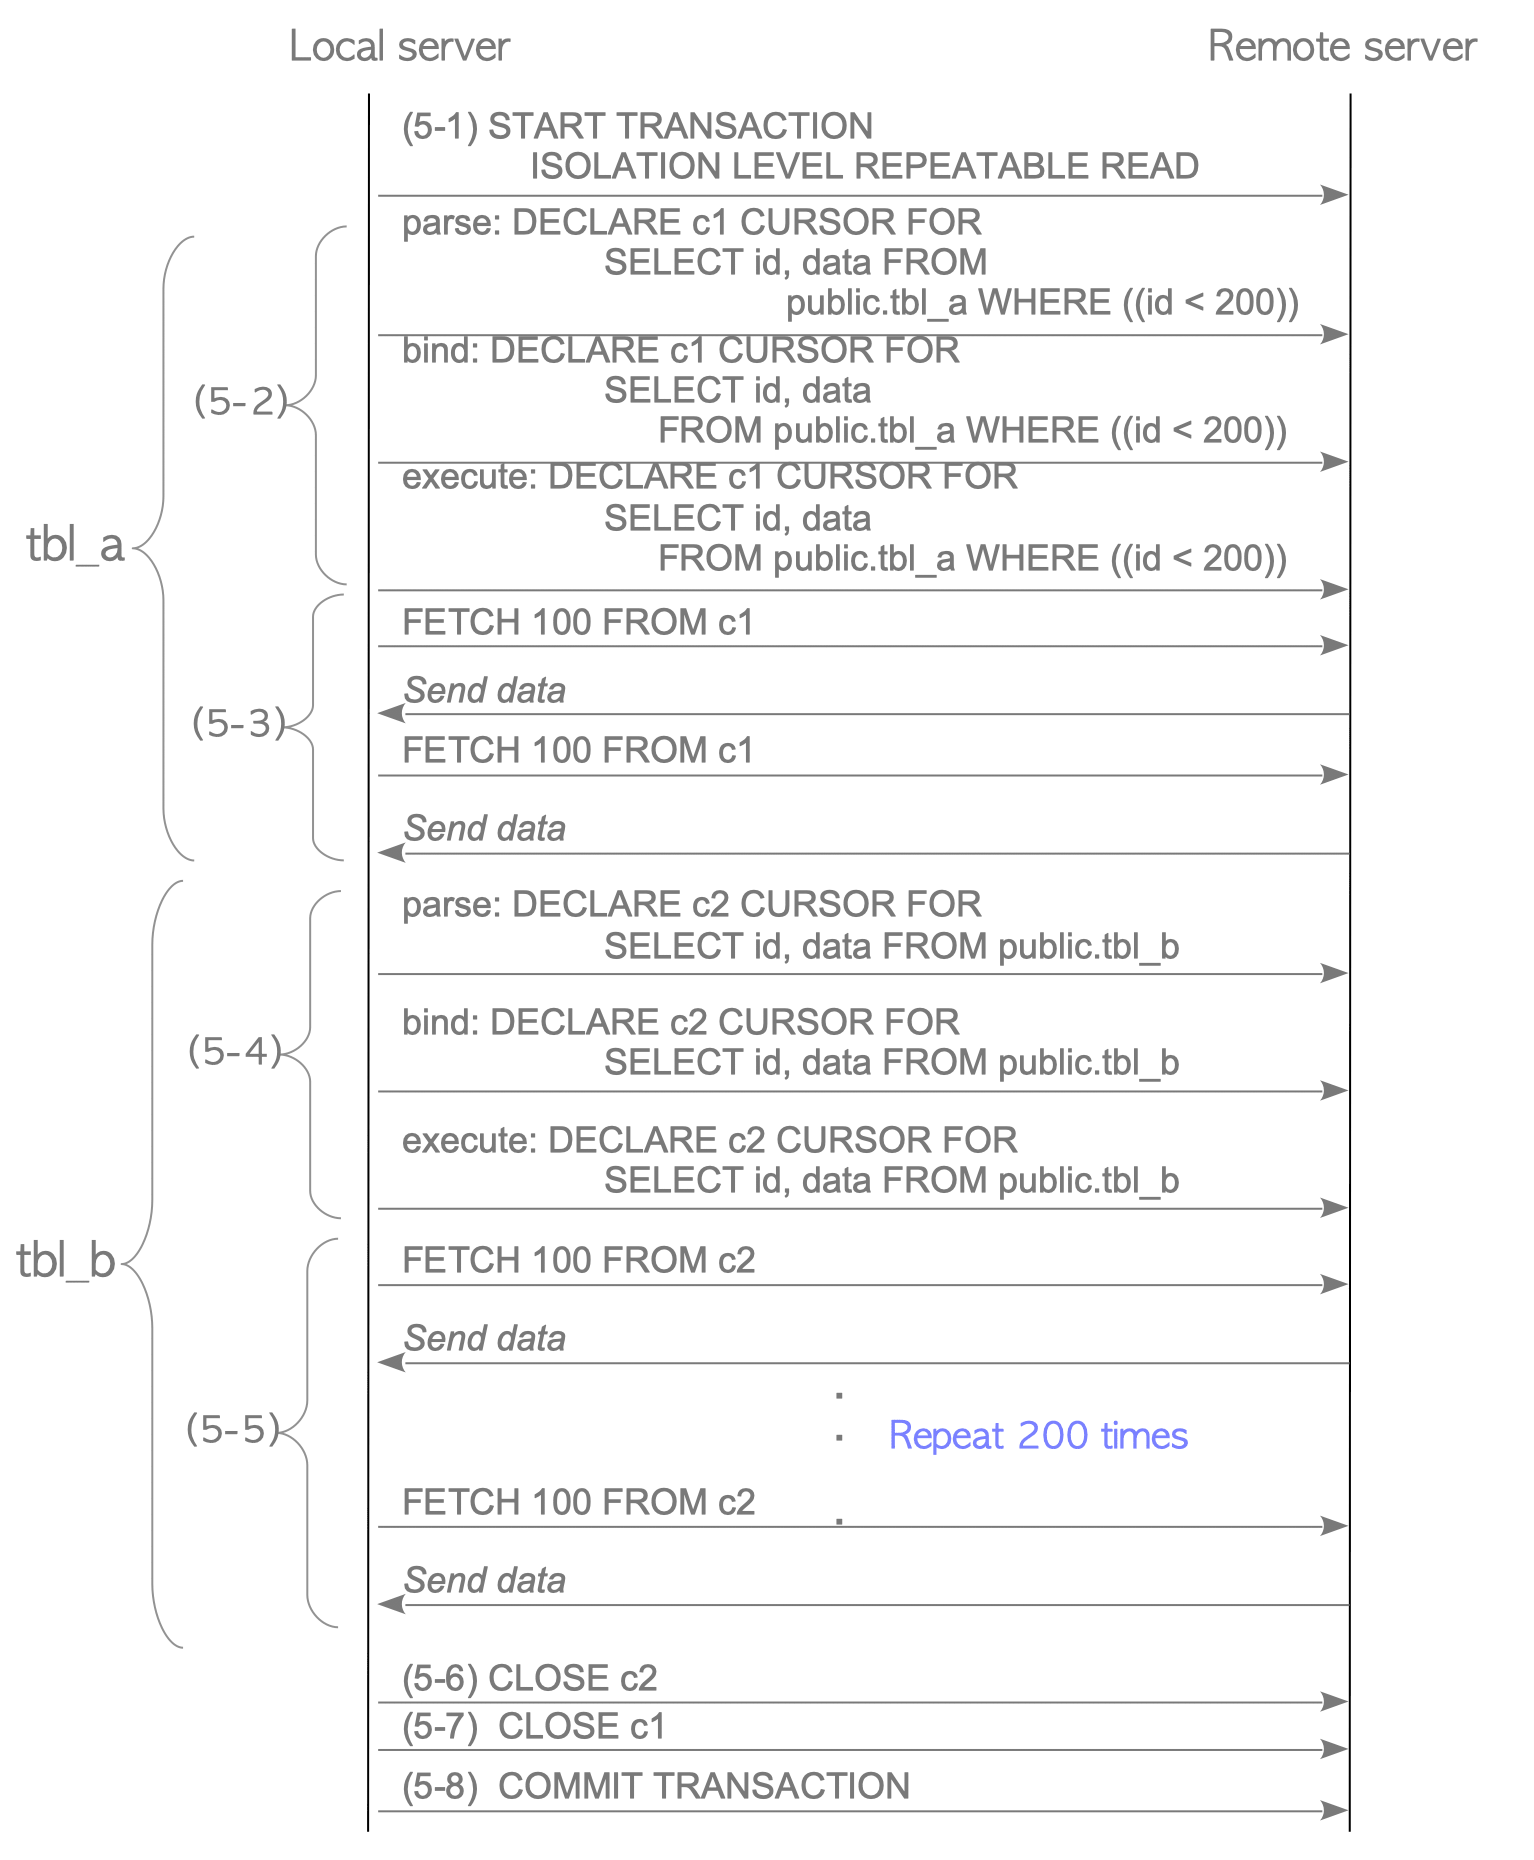

1. 원격 트랜잭션을 시작.

2. 커서 c1을 선언. 그 SELECT 문은 다음과 같음.


```
SELECT id,data FROM public.tbl_a WHERE (id < 200)
```

3. FETCH 명령을 실행하여 커서 1의 결과를 가져옴.

4. 아래와 같이 SELECT 문이 표시된 커서 c2를 선언.

```
SELECT id,data FROM public.tbl_b
```

- 원래 두 테이블 쿼리의 WHERE 절은 "tbl_a.id = tbl_b.id AND tbl_a.id < 200".
- 따라서 앞서 설명한 것처럼 SELECT 문에 WHERE 절 "tbl_b.id < 200"을 논리적으로 추가할 수 있음.
- 그러나 postgres_fdw는 이 추론을 수행할 수 없음.
- 따라서 실행자는 WHERE 절 없이 SELECT 문을 실행해야 하며 외부 테이블 'tbl_b'의 모든 행을 가져와야 함.
- 이 프로세스는 네트워크를 통해 원격 서버에서 불필요한 행을 읽어야 하므로 비효율적.
- 또한 병합 조인을 실행하려면 수신된 행을 정렬해야 함.
5. 커서 2의 결과를 얻기 위해 FETCH 명령을 실행.

6. c1 커서를 닫음.

7. c2 커서를 닫음.

8. 트랜잭션을 커밋한다.

**원격 서버의 실제 로그**

```
LOG:  statement: START TRANSACTION ISOLATION LEVEL REPEATABLE READ
LOG:  parse <unnamed>: DECLARE c1 CURSOR FOR
      SELECT id, data FROM public.tbl_a WHERE ((id < 200))
LOG:  bind <unnamed>: DECLARE c1 CURSOR FOR
      SELECT id, data FROM public.tbl_a WHERE ((id < 200))
LOG:  execute <unnamed>: DECLARE c1 CURSOR FOR
      SELECT id, data FROM public.tbl_a WHERE ((id < 200))
LOG:  statement: FETCH 100 FROM c1
LOG:  statement: FETCH 100 FROM c1
LOG:  parse <unnamed>: DECLARE c2 CURSOR FOR
      SELECT id, data FROM public.tbl_b
LOG:  bind <unnamed>: DECLARE c2 CURSOR FOR
      SELECT id, data FROM public.tbl_b
LOG:  execute <unnamed>: DECLARE c2 CURSOR FOR
      SELECT id, data FROM public.tbl_b
LOG:  statement: FETCH 100 FROM c2
LOG:  statement: FETCH 100 FROM c2
LOG:  statement: FETCH 100 FROM c2
LOG:  statement: FETCH 100 FROM c2

... snip

LOG:  statement: FETCH 100 FROM c2
LOG:  statement: FETCH 100 FROM c2
LOG:  statement: FETCH 100 FROM c2
LOG:  statement: FETCH 100 FROM c2
LOG:  statement: CLOSE c2
LOG:  statement: CLOSE c1
LOG:  statement: COMMIT TRANSACTION
```

- 행을 수신한 후 Executor는 수신된 'tbl_a' 및 'tbl_b' 행을 모두 정렬한 후 정렬된 행과 병합 조인 작업을 실행.


**버전 9.6 이상**
- use_remote_estimate 옵션이 'on'(기본값은 'off') 인 경우 postgres_fdw는 외부 테이블과 관련된 모든 계획의 비용을 얻기 위해 여러 EXPLAIN 명령을 보냄.

- EXPLAIN 명령을 보내기 위해 postgres_fdw는 각 단일 테이블 쿼리의 EXPLAIN 명령과 SELECT 문의 EXPLAIN 명령을 모두 보내 원격 조인 작업을 실행.
- 이 예에서는 각 SELECT 문의 예상 비용을 얻기 위해 다음 7개의 EXPLAIN 명령이 원격 서버로 전송.
- 그런 다음 플래너는 가장 저렴한 계획을 선택.

```
(1) EXPLAIN SELECT id, data FROM public.tbl_a WHERE ((id < 200))
(2) EXPLAIN SELECT id, data FROM public.tbl_b
(3) EXPLAIN SELECT id, data FROM public.tbl_a WHERE ((id < 200)) ORDER BY id ASC NULLS LAST
(4) EXPLAIN SELECT id, data FROM public.tbl_a WHERE ((((SELECT null::integer)::integer) = id)) AND ((id < 200))
(5) EXPLAIN SELECT id, data FROM public.tbl_b ORDER BY id ASC NULLS LAST
(6) EXPLAIN SELECT id, data FROM public.tbl_b WHERE ((((SELECT null::integer)::integer) = id))
(7) EXPLAIN SELECT r1.id, r1.data, r2.id, r2.data FROM (public.tbl_a r1 INNER JOIN public.tbl_b r2 ON (((r1.id = r2.id)) AND ((r1.id < 200))))
```

- 플래너가 어떤 계획을 선택하는지 관찰하기 위해 로컬 서버에서 EXPLAIN 명령을 실행

```
localdb=# EXPLAIN SELECT * FROM tbl_a AS a, tbl_b AS b WHERE a.id = b.id AND a.id < 200;
                        QUERY PLAN                        
.Foreign Scan  (cost=134.35..244.45 rows=80 width=16)
   Relations: (public.tbl_a a) INNER JOIN (public.tbl_b b)
(2 rows)
```

- 결과 플래너는 원격 서버에서 처리되는 내부 조인 쿼리를 선택하는 것으로 나타났는데 이는 매우 효율적.




**버전 9.6 이상에서 원격 조인 작업을 실행하는 SQL 문의 순서**

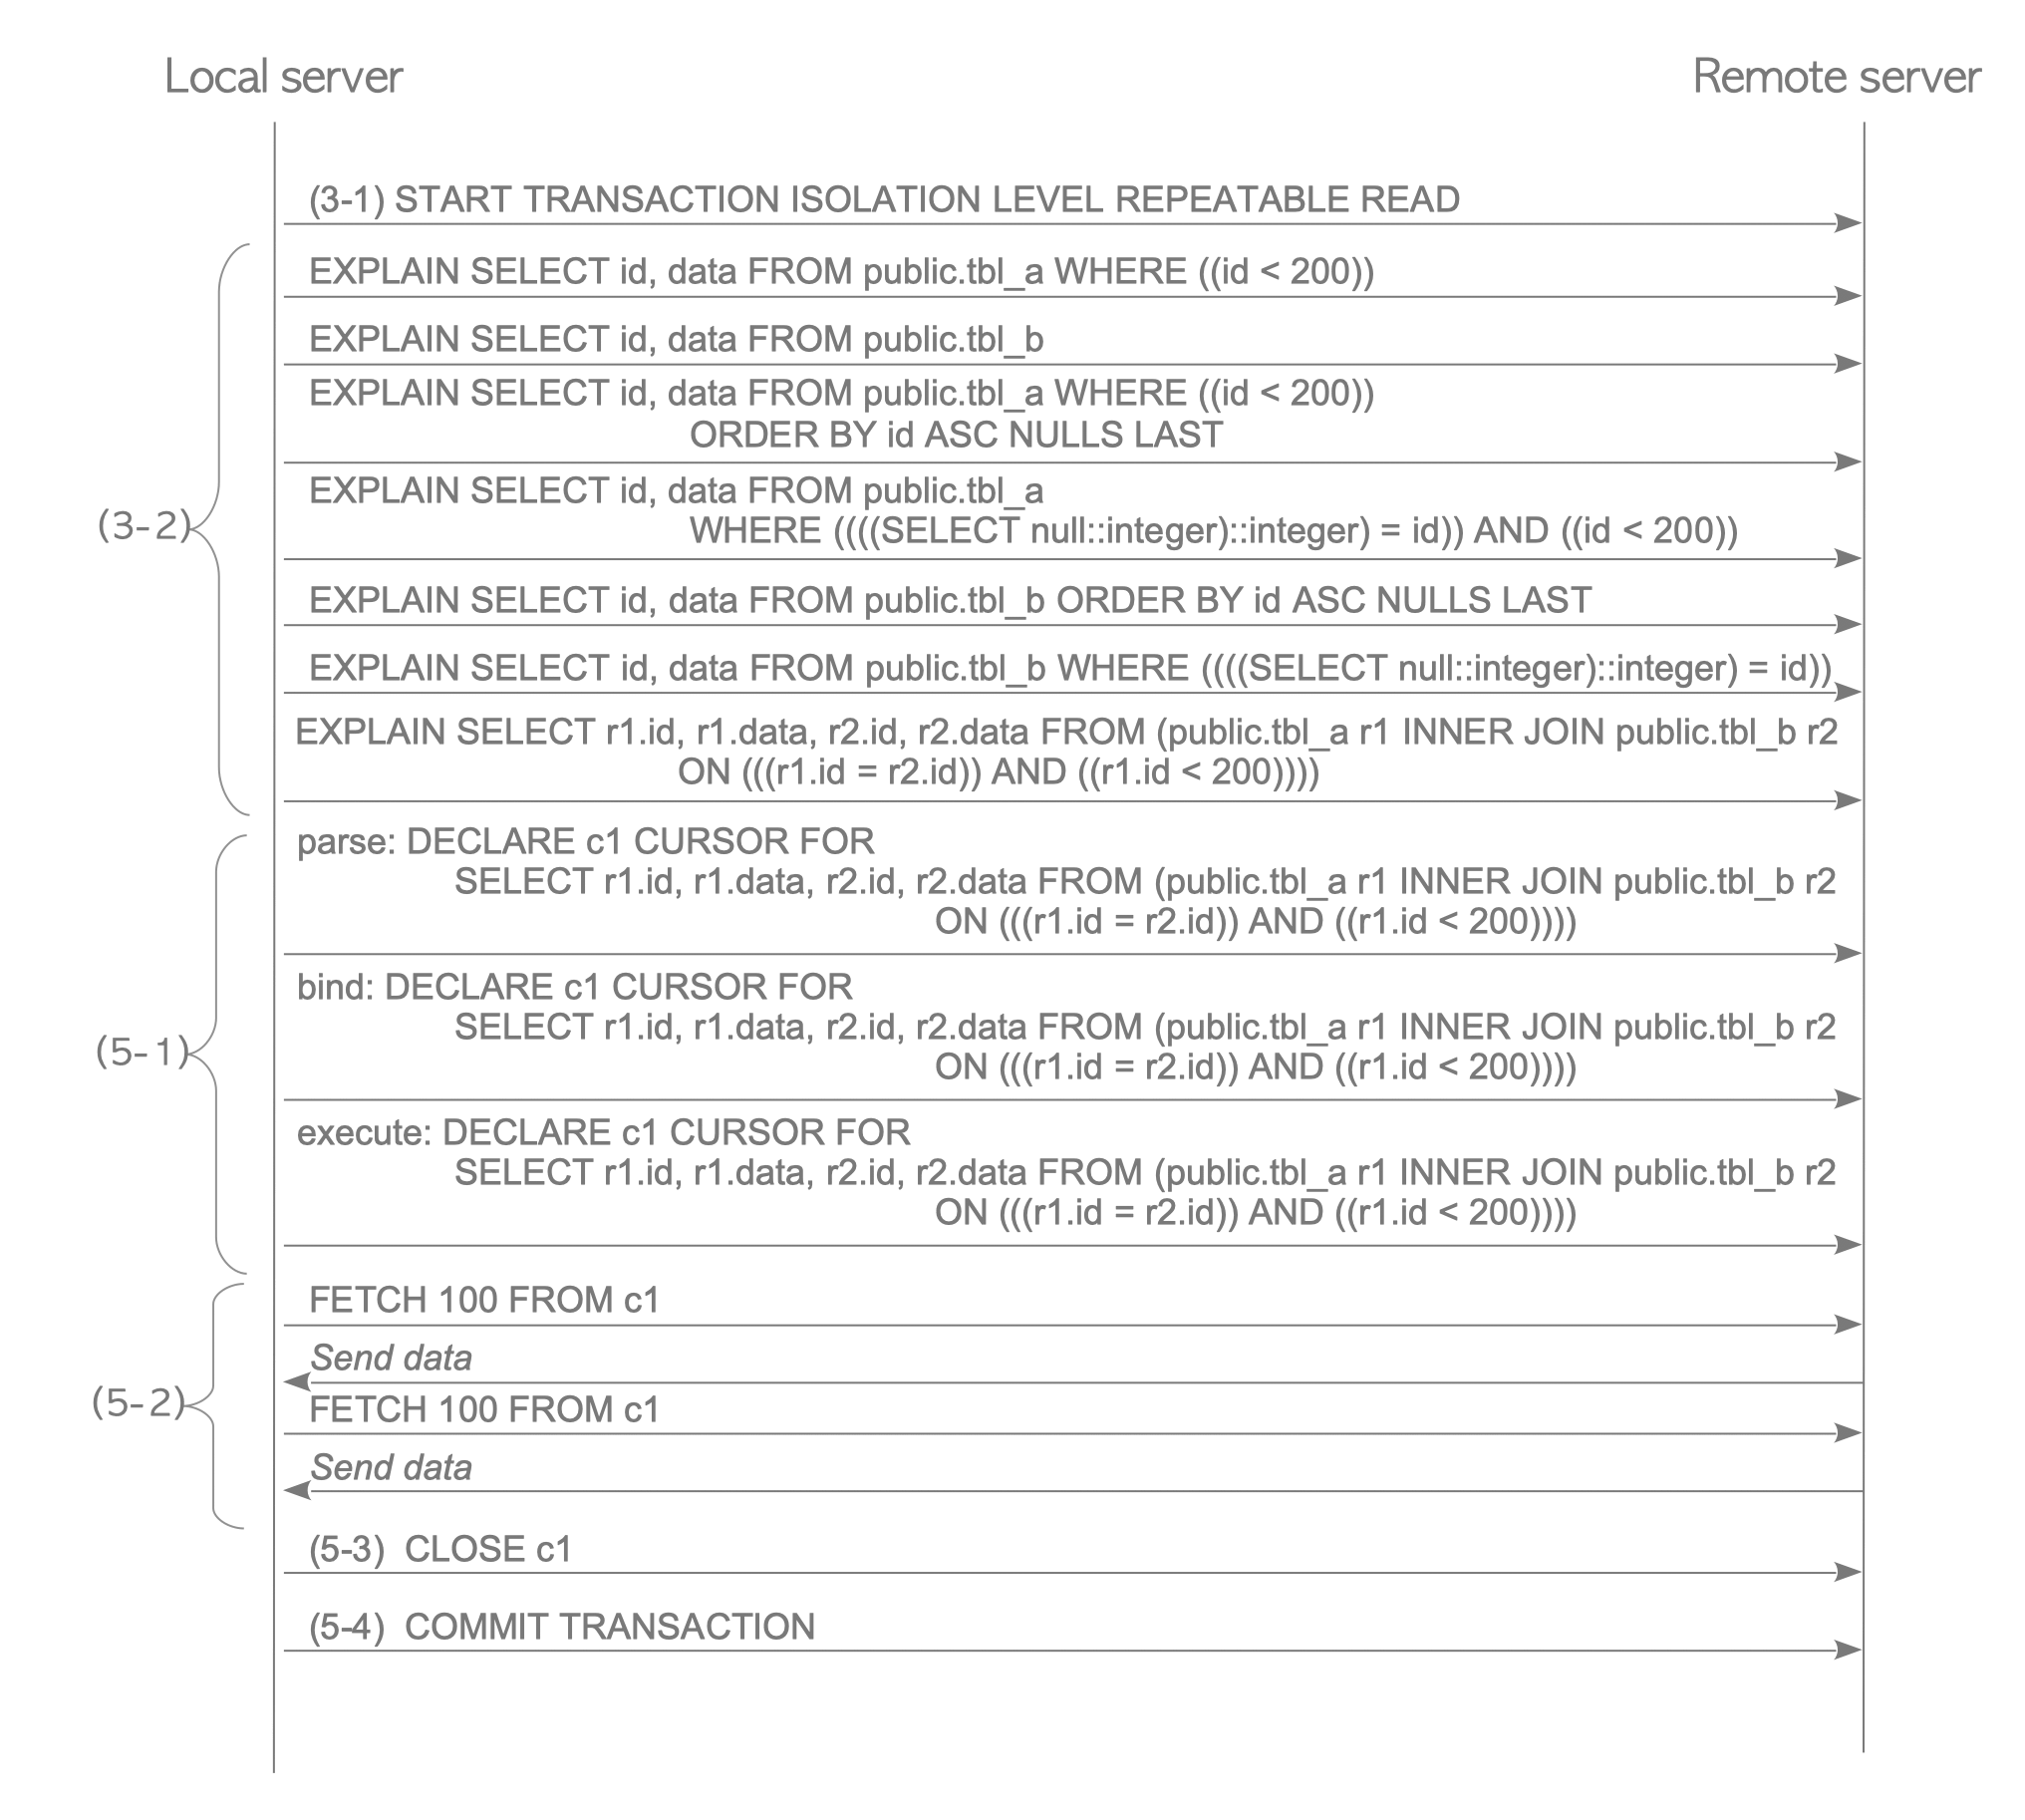

3-1. 원격 트랜잭션을 시작.

3-2. 각 계획 경로의 비용을 추정하기 위해 EXPLAIN 명령을 실행.

- 이 예에서는 7개의 EXPLAIN 명령이 실행.
- 그런 다음 플래너는 실행된 EXPLAIN 명령의 결과를 사용하여 SELECT 쿼리의 가장 저렴한 비용을 선택.

5-1. 아래와 같이 SELECT 문이 표시된 커서 c1을 선언.


```
SELECT r1.id, r1.data, r2.id, r2.data FROM (public.tbl_a r1 INNER JOIN public.tbl_b r2
  ON (((r1.id = r2.id)) AND ((r1.id < 200))))
```

5-2. 원격 서버로부터 결과를 받음.

5-3. c1 커서를 닫음.

5-4. 트랜잭션을 커밋.

**원격 서버의 실제 로그**

```
LOG:  statement: START TRANSACTION ISOLATION LEVEL REPEATABLE READ
LOG:  statement: EXPLAIN SELECT id, data FROM public.tbl_a WHERE ((id < 200))
LOG:  statement: EXPLAIN SELECT id, data FROM public.tbl_b
LOG:  statement: EXPLAIN SELECT id, data FROM public.tbl_a WHERE ((id < 200)) ORDER BY id ASC NULLS LAST
LOG:  statement: EXPLAIN SELECT id, data FROM public.tbl_a WHERE ((((SELECT null::integer)::integer) = id)) AND ((id < 200))
LOG:  statement: EXPLAIN SELECT id, data FROM public.tbl_b ORDER BY id ASC NULLS LAST
LOG:  statement: EXPLAIN SELECT id, data FROM public.tbl_b WHERE ((((SELECT null::integer)::integer) = id))
LOG:  statement: EXPLAIN SELECT r1.id, r1.data, r2.id, r2.data FROM (public.tbl_a r1 INNER JOIN public.tbl_b r2 ON (((r1.id = r2.id)) AND ((r1.id < 200))))
LOG:  parse: DECLARE c1 CURSOR FOR
	   SELECT r1.id, r1.data, r2.id, r2.data FROM (public.tbl_a r1 INNER JOIN public.tbl_b r2 ON (((r1.id = r2.id)) AND ((r1.id < 200))))
LOG:  bind: DECLARE c1 CURSOR FOR
	   SELECT r1.id, r1.data, r2.id, r2.data FROM (public.tbl_a r1 INNER JOIN public.tbl_b r2 ON (((r1.id = r2.id)) AND ((r1.id < 200))))
LOG:  execute: DECLARE c1 CURSOR FOR
	   SELECT r1.id, r1.data, r2.id, r2.data FROM (public.tbl_a r1 INNER JOIN public.tbl_b r2 ON (((r1.id = r2.id)) AND ((r1.id < 200))))
LOG:  statement: FETCH 100 FROM c1
LOG:  statement: FETCH 100 FROM c1
LOG:  statement: CLOSE c1
LOG:  statement: COMMIT TRANSACTION
```

- use_remote_estimate 옵션이 꺼져 있으면(기본적으로) 매우 큰 내장 값을 사용하여 비용을 추정하기 때문에 원격 조인 쿼리가 거의 선택되지 않음.

# **정렬 작업**

**버전 9.5 이하**

- ORDER BY와 같은 정렬 작업은 로컬 서버에서 처리.
- 이는 로컬 서버가 정렬 작업 전에 원격 서버에서 모든 대상 행을 가져오는 것을 의미.


**EXPLAIN 명령을 사용하여 ORDER BY 절이 포함된 간단한 쿼리를 처리하는 방법**

```

localdb=# EXPLAIN SELECT * FROM tbl_a AS a WHERE a.id < 200 ORDER BY a.id;
                              QUERY PLAN                               
-----------------------------------------------------------------------
 Sort  (cost=200.59..202.72 rows=853 width=8)
   Sort Key: id
   ->  Foreign Scan on tbl_a a  (cost=100.00..159.06 rows=853 width=8)
(3 rows)
```

- 6행 : 실행자는 원격 서버에 다음 쿼리를 보낸 후 쿼리 결과를 가져옴.

```
SELECT id, data FROM public.tbl_a WHERE ((id < 200))
```

- 4행 : 실행기는 로컬 서버에서 가져온 'tbl_a' 행을 정렬.

**원격 서버의 실제 로그**

```
LOG:  statement: START TRANSACTION ISOLATION LEVEL REPEATABLE READ
LOG:  parse <unnamed>: DECLARE c1 CURSOR FOR
      SELECT id, data FROM public.tbl_a WHERE ((id < 200))
LOG:  bind <unnamed>: DECLARE c1 CURSOR FOR
      SELECT id, data FROM public.tbl_a WHERE ((id < 200))
LOG:  execute <unnamed>: DECLARE c1 CURSOR FOR
      SELECT id, data FROM public.tbl_a WHERE ((id < 200))
LOG:  statement: FETCH 100 FROM c1
LOG:  statement: FETCH 100 FROM c1
LOG:  statement: CLOSE c1
LOG:  statement: COMMIT TRANSACTION
```


**버전 9.6 이상**

- postgres_fdw는 가능하면 원격 서버에서 ORDER BY 절을 사용하여 SELECT 문을 실행할 수 있음.

```
localdb=# EXPLAIN SELECT * FROM tbl_a AS a WHERE a.id < 200 ORDER BY a.id;
                           QUERY PLAN                            
-----------------------------------------------------------------
 Foreign Scan on tbl_a a  (cost=100.00..167.46 rows=853 width=8)
(1 row)
```

- 4행 : Executor는 ORDER BY 절이 포함된 다음 쿼리를 원격 서버로 보낸 후 이미 정렬된 쿼리 결과를 가져옴.

```
SELECT id, data FROM public.tbl_a WHERE ((id < 200)) ORDER BY id ASC NULLS LAST
```

**원격 서버의 실제 로그**

```
LOG:  statement: START TRANSACTION ISOLATION LEVEL REPEATABLE READ
LOG:  parse <unnamed>: DECLARE c1 CURSOR FOR
	   SELECT id, data FROM public.tbl_a WHERE ((id < 200)) ORDER BY id ASC NULLS LAST
LOG:  bind <unnamed>: DECLARE c1 CURSOR FOR
	   SELECT id, data FROM public.tbl_a WHERE ((id < 200)) ORDER BY id ASC NULLS LAST
LOG:  execute <unnamed>: DECLARE c1 CURSOR FOR
	   SELECT id, data FROM public.tbl_a WHERE ((id < 200)) ORDER BY id ASC NULLS LAST
LOG:  statement: FETCH 100 FROM c1
LOG:  statement: FETCH 100 FROM c1
LOG:  statement: CLOSE c1
LOG:  statement: COMMIT TRANSACTION
```

- 이러한 개선으로 로컬 서버의 작업 부하가 감소.

**버전 9.6 이하**

- 이전 하위 섹션에서 언급한 정렬 작업과 유사하게 AVG() 및 COUNT()와 같은 집계 함수는 다음 단계에 따라 로컬 서버에서 처리.

```
localdb=# EXPLAIN SELECT AVG(data) FROM tbl_a AS a WHERE a.id < 200;
                              QUERY PLAN                               
-----------------------------------------------------------------------
 Aggregate  (cost=168.50..168.51 rows=1 width=4)
   ->  Foreign Scan on tbl_a a  (cost=100.00..166.06 rows=975 width=4)
(2 rows)
```

- 5행 : 실행자는 원격 서버에 다음 쿼리를 보낸 후 쿼리 결과를 가져옴.

```
SELECT id, data FROM public.tbl_a WHERE ((id < 200))
```

- 4행 : 실행기는 로컬 서버에서 가져온 'tbl_a' 행의 평균을 계산

**원격 서버의 실제 로그**

```
LOG:  statement: START TRANSACTION ISOLATION LEVEL REPEATABLE READ
LOG:  parse <unnamed>: DECLARE c1 CURSOR FOR
      SELECT data FROM public.tbl_a WHERE ((id < 200))
LOG:  bind <unnamed>: DECLARE c1 CURSOR FOR
      SELECT data FROM public.tbl_a WHERE ((id < 200))
LOG:  execute <unnamed>: DECLARE c1 CURSOR FOR
      SELECT data FROM public.tbl_a WHERE ((id < 200))
LOG:  statement: FETCH 100 FROM c1
LOG:  statement: FETCH 100 FROM c1
LOG:  statement: CLOSE c1
LOG:  statement: COMMIT TRANSACTION
```

- 많은 수의 행을 보내면 네트워크 트래픽이 많이 소비되고 시간이 오래 걸리기 때문에 이 프로세스에는 비용이 많이 듬.

**버전 10 이상**

- postgres_fdw는 가능하면 원격 서버에서 집계 함수를 사용하여 SELECT 문을 실행.


```
localdb=# EXPLAIN SELECT AVG(data) FROM tbl_a AS a WHERE a.id < 200;
                     QUERY PLAN                      
-----------------------------------------------------
 Foreign Scan  (cost=102.44..149.03 rows=1 width=32)
   Relations: Aggregate on (public.tbl_a a)
(2 rows)
```

- 4행 : 실행자는 AVG() 함수가 포함된 다음 쿼리를 원격 서버로 보낸 다음 쿼리 결과를 가져옴.

```
SELECT avg(data) FROM public.tbl_a WHERE ((id < 200))
```

**원격 서버의 실제 로그**

```
LOG:  statement: START TRANSACTION ISOLATION LEVEL REPEATABLE READ
LOG:  parse <unnamed>: DECLARE c1 CURSOR FOR
	   SELECT avg(data) FROM public.tbl_a WHERE ((id < 200))
LOG:  bind <unnamed>: DECLARE c1 CURSOR FOR
	   SELECT avg(data) FROM public.tbl_a WHERE ((id < 200))
LOG:  execute <unnamed>: DECLARE c1 CURSOR FOR
	   SELECT avg(data) FROM public.tbl_a WHERE ((id < 200))
LOG:  statement: FETCH 100 FROM c1
LOG:  statement: CLOSE c1
LOG:  statement: COMMIT TRANSACTION

```

- 이 프로세스는 원격 서버가 평균을 계산하고 결과로 하나의 행만 보내기 때문에 분명히 효율적.

**Push-Down**

- 주어진 예와 유사하게 푸시다운은 로컬 서버가 원격 서버가 집계 프로시저와 같은 일부 작업을 처리하도록 허용하는 작업.